Reproducing the orbit of a binary system: White Dwarf + L-subdwarf (https://ui.adsabs.harvard.edu/abs/2024MNRAS.533.1654Z/abstract)

In [1]:
import numpy as np
import pylab as pl
from scipy import stats
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from astropy import units
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

  Referenced from: '/Users/mc/anaconda3/lib/python3.11/site-packages/libgalpy.cpython-311-darwin.so'
  Reason: tried: '/Users/mc/anaconda3/lib/python3.11/site-packages/../../libgsl.25.dylib' (no such file), '/Users/mc/anaconda3/lib/python3.11/site-packages/../../libgsl.25.dylib' (no such file), '/Users/mc/anaconda3/lib/python3.11/lib-dynload/../../libgsl.25.dylib' (no such file), '/Users/mc/anaconda3/bin/../lib/libgsl.25.dylib' (no such file), '/usr/local/lib/libgsl.25.dylib' (no such file), '/usr/lib/libgsl.25.dylib' (no such file)'


Creating arrays for initial orbital parameters (observations) and uncertainties (+/- 1 sigma and +/- 2 sigma)

In [5]:
# RA (deg), DEC (deg), parallax (mas), pmra (mas/yr), pmdec (mas/yr), rv (km/s)

mean = np.array([194.1812246704677, -62.03559791438614, 1.32366530e+01, -1.12404404e+03,  2.41409108e+01, -4.63900000e+01])

sigma = np.array([0, 0, 3.2619340e-01, 2.6835763e-01, 3.2455158e-01, 1.4500000e+00])

normal_1000 = np.random.normal(mean, sigma, size=(1000,len(mean)))
normal_10000 = np.random.normal(mean, sigma, size=(10000,len(mean)))

# -1 sigma: RA (deg), DEC (deg), distance (kpc) = 1/parallax (mas), pmra (mas/yr), pmdec (mas/yr), rv (km/s)
sigma1m = [stats.scoreatpercentile(normal_10000[:,0],16),stats.scoreatpercentile(normal_10000[:,1],16),stats.scoreatpercentile(1/normal_10000[:,2],16),
           stats.scoreatpercentile(normal_10000[:,3],16),stats.scoreatpercentile(normal_10000[:,4],16),stats.scoreatpercentile(normal_10000[:,5],16)]

# +1 sigma: RA (deg), DEC (deg), distance (kpc) = 1/parallax (mas), pmra (mas/yr), pmdec (mas/yr), rv (km/s)
sigma1p = [stats.scoreatpercentile(normal_10000[:,0],84),stats.scoreatpercentile(normal_10000[:,1],84),stats.scoreatpercentile(1/normal_10000[:,2],84),
           stats.scoreatpercentile(normal_10000[:,3],84),stats.scoreatpercentile(normal_10000[:,4],84),stats.scoreatpercentile(normal_10000[:,5],84)]

# -2 sigma: RA (deg), DEC (deg), distance (kpc) = 1/parallax (mas), pmra (mas/yr), pmdec (mas/yr), rv (km/s)
sigma2m = [stats.scoreatpercentile(normal_10000[:,0],2.5),stats.scoreatpercentile(normal_10000[:,1],2.5),stats.scoreatpercentile(1/normal_10000[:,2],2.5),
           stats.scoreatpercentile(normal_10000[:,3],2.5),stats.scoreatpercentile(normal_10000[:,4],2.5),stats.scoreatpercentile(normal_10000[:,5],2.5)]

# +2 sigma: RA (deg), DEC (deg), distance (kpc) = 1/parallax (mas), pmra (mas/yr), pmdec (mas/yr), rv (km/s)
sigma2p = [stats.scoreatpercentile(normal_10000[:,0],97.5),stats.scoreatpercentile(normal_10000[:,1],97.5),stats.scoreatpercentile(1/normal_10000[:,2],97.5),
           stats.scoreatpercentile(normal_10000[:,3],97.5),stats.scoreatpercentile(normal_10000[:,4],97.5),stats.scoreatpercentile(normal_10000[:,5],97.5)]


Printing values

In [6]:
print("mean:", mean)
print("sigma:", sigma)
print("-1 sigma:", sigma1m)

mean: [  194.18122467   -62.03559791    13.236653   -1124.04404
    24.1409108    -46.39      ]
sigma: [0.         0.         0.3261934  0.26835763 0.32455158 1.45      ]
-1 sigma: [194.1812246704677, -62.03559791438614, 0.07373181252460327, -1124.3105153629535, 23.80642699492941, -47.817251024263484]


Loading Milky Way's potential and setting the integration timesteps

In [7]:
### load Milky Way's model
MW = MWPotential2014
u_sun, v_sun, w_sun = 11.1, 12.24, 7.25
R0, V0 = 8.178, 235

### define age intervals backward/forward
ages_b = -np.linspace(0,2,1000)
ages_b.sort()
ages_f = np.linspace(0,2,1000)
ages = np.hstack((ages_b[:-1],ages_f))

####
tm = ages[np.where(ages<0)]*units.Gyr
tp = ages[np.where(ages>=0)]*units.Gyr

### integration timesteps on a finer grid ###
ts = np.linspace(0,2,2000)*units.Gyr




Initializing the Orbit object and integrating the orbit

In [8]:

### orbit forward for 1000 random samples: takes a few minutes ###
#f = Orbit(normal_1000,radec=True,ro=R0,vo=V0,solarmotion=[-u_sun,v_sun,w_sun])
#f.integrate(ts, MW, method='symplec4_c')


### orbit for mean values ###
fwd = [mean[0],mean[1],1/mean[2],mean[3],mean[4],mean[5]]

f = Orbit(fwd,radec=True,ro=R0,vo=V0,solarmotion=[-u_sun,v_sun,w_sun])
f.integrate(ts, MW, method='symplec4_c')
# backward flipped orbits #   
b = f.flip()
b.integrate(ts, MW, method='symplec4_c')
  
# print eccentricity and angular momentum ###
print("mean values: e = {:.2f}".format(f.e()), " - Lz = {:.0f}".format(f.Lz()), "kpc km/s")

Rm,Xm,Ym,Zm = b.R(-tm),b.x(-tm),b.y(-tm),b.z(-tm)
Rp,Xp,Yp,Zp = f.R(tp),f.x(tp),f.y(tp),f.z(tp)

### 2m: sigma ####
f = Orbit(sigma2m,radec=True,ro=R0,vo=V0,solarmotion=[-u_sun,v_sun,w_sun])
f.integrate(ts, MW, method='symplec4_c')
# backward flipped orbits #   
b = f.flip()
b.integrate(ts, MW, method='symplec4_c')
# print eccentricity and angular momentum ###
print("-2 sigma: e = {:.2f}".format(f.e()), " - Lz = {:.0f}".format(f.Lz()), "kpc km/s") 

R2mm,X2mm,Y2mm,Z2mm = b.R(-tm),b.x(-tm),b.y(-tm),b.z(-tm)
R2mp,X2mp,Y2mp,Z2mp = f.R(tp),f.x(tp),f.y(tp),f.z(tp)


### 2p: sigma ####
f = Orbit(sigma2p,radec=True,ro=R0,vo=V0,solarmotion=[-u_sun,v_sun,w_sun])
f.integrate(ts, MW, method='symplec4_c')
# backward flipped orbits #   
b = f.flip()
b.integrate(ts, MW, method='symplec4_c')
# print eccentricity and angular momentum ###
print("+2 sigma: e = {:.2f}".format(f.e()), " - Lz = {:.0f}".format(f.Lz()), "kpc km/s")

R2pm,X2pm,Y2pm,Z2pm = b.R(-tm),b.x(-tm),b.y(-tm),b.z(-tm)
R2pp,X2pp,Y2pp,Z2pp = f.R(tp),f.x(tp),f.y(tp),f.z(tp)

### 1m: sigma ####
f = Orbit(sigma1m,radec=True,ro=R0,vo=V0,solarmotion=[-u_sun,v_sun,w_sun])
f.integrate(ts, MW, method='symplec4_c')
# backward flipped orbits #   
b = f.flip()
b.integrate(ts, MW, method='symplec4_c')
# print eccentricity and angular momentum ###
print("-1 sigma: e = {:.2f}".format(f.e()), " - Lz = {:.0f}".format(f.Lz()), "kpc km/s")  

R1mm,X1mm,Y1mm,Z1mm = b.R(-tm),b.x(-tm),b.y(-tm),b.z(-tm)
R1mp,X1mp,Y1mp,Z1mp = f.R(tp),f.x(tp),f.y(tp),f.z(tp)

### 1p: sigma ####
f = Orbit(sigma1p,radec=True,ro=R0,vo=V0,solarmotion=[-u_sun,v_sun,w_sun])
f.integrate(ts, MW, method='symplec4_c')
# backward flipped orbits #   
b = f.flip()
b.integrate(ts, MW, method='symplec4_c')
# print eccentricity and angular momentum ###
print("+1 sigma: e = {:.2f}".format(f.e()), " - Lz = {:.0f}".format(f.Lz()), "kpc km/s")  

R1pm,X1pm,Y1pm,Z1pm = b.R(-tm),b.x(-tm),b.y(-tm),b.z(-tm)
R1pp,X1pp,Y1pp,Z1pp = f.R(tp),f.x(tp),f.y(tp),f.z(tp)



mean values: e = 0.94  - Lz = 541 kpc km/s
-2 sigma: e = 0.92  - Lz = 641 kpc km/s
+2 sigma: e = 0.96  - Lz = 431 kpc km/s
-1 sigma: e = 0.93  - Lz = 593 kpc km/s
+1 sigma: e = 0.95  - Lz = 486 kpc km/s


Plotting a nice figure of the orbit

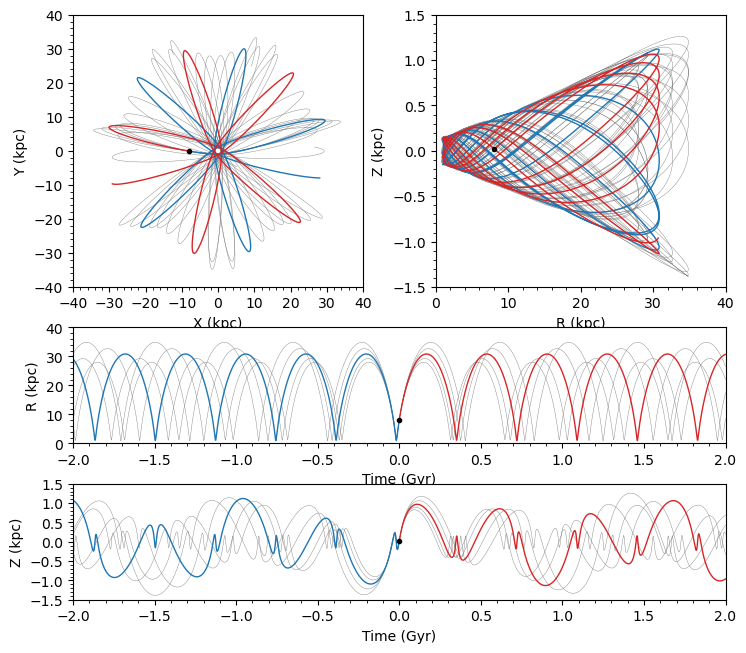

In [9]:
fig = pl.figure(figsize=(7.5,6.5))
fig.subplots_adjust(left=0.08,top=0.98,right=0.95,bottom=0.08,hspace=0.35,wspace=0.25)
gs = gridspec.GridSpec(4,2)



ax1 = fig.add_subplot(gs[0:2,0])
#ax1.set_rasterization_zorder(0)
pl.plot(-X1mm, Y1mm, color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(-X1mp, Y1mp, color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(-X1pm, Y1pm, color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(-X1pp, Y1pp, color='grey', lw=0.3, zorder=-2, rasterized=True) 

pl.plot(-X2mm, Y2mm, color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(-X2mp, Y2mp, color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(-X2pm, Y2pm, color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(-X2pp, Y2pp, color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(-Xp[0], Yp[0], 'ko', ms=3,zorder=10) 

pl.plot(-Xm, Ym, lw=1,  color='C0') 
pl.plot(-Xp, Yp, lw=1,  color='C3') 

ax1.set_xlabel('X (kpc)')
ax1.set_ylabel('Y (kpc)')

majorLocator = MultipleLocator(10)
minorLocator = MultipleLocator(2)

ax1.xaxis.set_major_locator(majorLocator)
ax1.xaxis.set_minor_locator(minorLocator)

ax1.yaxis.set_major_locator(majorLocator)
ax1.yaxis.set_minor_locator(minorLocator)


ax1.set_xlim([-40,40])
ax1.set_ylim([-40,40])


ax2 = fig.add_subplot(gs[0:2,1])
#ax2.set_rasterization_zorder(0)
#for j in n:
#   pl.plot(np.sqrt(pow(S['x'][j],2)+pow(S['y'][j],2)), S['z'][j], color='grey', lw=0.05, zorder=-2, rasterized=True) 
pl.plot(np.sqrt(X1mm**2 + Y1mm**2), Z1mm,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(np.sqrt(X1mp**2 + Y1mp**2), Z1mp,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(np.sqrt(X1pm**2 + Y1pm**2), Z1pm,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(np.sqrt(X1pp**2 + Y1pp**2), Z1pp,color='grey', lw=0.3, zorder=-2, rasterized=True) 

pl.plot(np.sqrt(X2mm**2 + Y2mm**2), Z2mm,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(np.sqrt(X2mp**2 + Y2mp**2), Z2mp,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(np.sqrt(X2pm**2 + Y2pm**2), Z2pm,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(np.sqrt(X2pp**2 + Y2pp**2), Z2pp,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(np.sqrt(Xp[0]**2 + Yp[0]), Zp[0], 'ko', ms=3,zorder=10) 

pl.plot(np.sqrt(pow(Xm,2)+pow(Ym,2)), Zm, lw=1,  color='C0') 
pl.plot(np.sqrt(pow(Xp,2)+pow(Yp,2)), Zp, lw=1,  color='C3') 

ax2.set_xlabel('R (kpc)')
ax2.set_ylabel('Z (kpc)')

majorLocator = MultipleLocator(10)
minorLocator = MultipleLocator(2)

ax2.xaxis.set_major_locator(majorLocator)
ax2.xaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(0.5)
minorLocator = MultipleLocator(0.1)

ax2.yaxis.set_major_locator(majorLocator)
ax2.yaxis.set_minor_locator(minorLocator)

ax2.set_xlim([0,40])
ax2.set_ylim([-1.5,1.5])

ax3 = fig.add_subplot(gs[2,0:2])
#ax3.set_rasterization_zorder(0)
#for j in n:
#   pl.plot(ages/1000, np.sqrt(pow(S['x'][j],2)+pow(S['y'][j],2)), color='grey', lw=0.05, zorder=-2, rasterized=True) 
pl.plot(tm, np.sqrt(X1mm**2 + Y1mm**2),color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tp, np.sqrt(X1mp**2 + Y1mp**2),color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tm, np.sqrt(X1pm**2 + Y1pm**2),color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tp, np.sqrt(X1pp**2 + Y1pp**2),color='grey', lw=0.3, zorder=-2, rasterized=True) 

pl.plot(tm, np.sqrt(X2mm**2 + Y2mm**2),color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tp, np.sqrt(X2mp**2 + Y2mp**2),color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tm, np.sqrt(X2pm**2 + Y2pm**2),color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tp, np.sqrt(X2pp**2 + Y2pp**2),color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(0,np.sqrt(Xp[0]**2 + Yp[0]**2), 'ko', ms=3,zorder=10) 

pl.plot(tm, np.sqrt(pow(Xm,2)+pow(Ym,2)), lw=1,  color='C0') 
pl.plot(tp, np.sqrt(pow(Xp,2)+pow(Yp,2)), lw=1,  color='C3') 

ax3.set_xlabel('Time (Gyr)')
ax3.set_ylabel('R (kpc)')

majorLocator = MultipleLocator(0.5)
minorLocator = MultipleLocator(0.1)

ax3.xaxis.set_major_locator(majorLocator)
ax3.xaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(10)
minorLocator = MultipleLocator(2)

ax3.yaxis.set_major_locator(majorLocator)
ax3.yaxis.set_minor_locator(minorLocator)

ax3.set_xlim([-2,2])
ax3.set_ylim([0,40])


ax4 = fig.add_subplot(gs[3,0:2])
#ax4.set_rasterization_zorder(0)
#for j in n:
#   pl.plot(ages/1000, S['z'][j], color='grey', lw=0.05, zorder=-2, rasterized=True) 
pl.plot(tm, Z1mm,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tp, Z1mp,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tm, Z1pm,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tp, Z1pp,color='grey', lw=0.3, zorder=-2, rasterized=True) 

pl.plot(tm, Z2mm,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tp, Z2mp,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tm, Z2pm,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(tp, Z2pp,color='grey', lw=0.3, zorder=-2, rasterized=True) 
pl.plot(0, Zp[0], 'ko', ms=3,zorder=10) 

pl.plot(tm, Zm, lw=1,  color='C0')     
pl.plot(tp, Zp, lw=1,  color='C3')     

ax4.set_xlabel('Time (Gyr)')
ax4.set_ylabel('Z (kpc)')

majorLocator = MultipleLocator(0.5)
minorLocator = MultipleLocator(0.1)

ax4.xaxis.set_major_locator(majorLocator)
ax4.xaxis.set_minor_locator(minorLocator)

majorLocator = MultipleLocator(0.5)
minorLocator = MultipleLocator(0.1)

ax4.yaxis.set_major_locator(majorLocator)
ax4.yaxis.set_minor_locator(minorLocator)


ax4.set_xlim([-2,2])
ax4.set_ylim([-1.5,1.5])

pl.show()